# Мещерякова Ксения, 932003

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop

In [2]:
# Гиперпараметры (закомментированные числа - это числа, которые я бы хотела использовать, но у меня не хватает терпения дождаться результатов)
IMG_HEIGHT = IMG_WIDTH = 150
IMG_CHANNEL = 3
EPOCHS = 5 #30
BATCH_SIZE = 60 #16
TRAIN_SAMPLES = 2000 #10625
VAL_SAMPLES = 700
TEST_SAMPLES = 700

In [3]:
# Каталоги с данными
train_dir = 'train'
validation_dir = 'val'
test_dir = 'test'

In [4]:
# Генераторы изображений
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [5]:
test_and_val_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
# Обучающая, тестовая и валидационная выборки
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical')  

validation_generator = test_and_val_datagen.flow_from_directory(
    validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical')  

test_generator = test_and_val_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 14145 images belonging to 3 classes.
Found 950 images belonging to 3 classes.
Found 950 images belonging to 3 classes.


In [10]:
# Используем VGG16
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNEL))


58889256/58889256 [==============================] - 536s 9us/step


In [11]:
# Модель обрабатывает входные данные от первого слоя к последнему
model = tf.keras.models.Sequential()
model.add(conv_base)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(3, activation='softmax'))  # Three classes

In [12]:
conv_base.trainable = False

In [13]:
# Разморозка всех слоев сверточной базы
conv_base.trainable = True

# Заморозка слоев до определенного слоя по имени
layers_to_freeze_until = 'block5_conv1'
for layer in conv_base.layers:
    if layer.name == layers_to_freeze_until:
        break
    layer.trainable = False

In [14]:
#Компилируем модель после любых изменений в trainable
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['acc'])

In [19]:
checkpoint_cb = ModelCheckpoint("best_model.h5", save_best_only=True)


In [17]:
# Обучение
history = model.fit(
    train_generator,
    steps_per_epoch=TRAIN_SAMPLES // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=VAL_SAMPLES // BATCH_SIZE)

Epoch 1/5
33/33 [==============================] - 694s 21s/step - loss: 1.7262 - acc: 0.5000 - val_loss: 1.0950 - val_acc: 0.3750
Epoch 2/5
33/33 [==============================] - 756s 23s/step - loss: 1.0701 - acc: 0.5038 - val_loss: 1.0903 - val_acc: 0.3920
Epoch 3/5
33/33 [==============================] - 1029s 32s/step - loss: 1.0487 - acc: 0.5170 - val_loss: 1.1046 - val_acc: 0.3750
Epoch 4/5
33/33 [==============================] - 868s 26s/step - loss: 1.0260 - acc: 0.5284 - val_loss: 1.1308 - val_acc: 0.3693
Epoch 5/5
33/33 [==============================] - 803s 24s/step - loss: 1.0482 - acc: 0.4886 - val_loss: 1.1723 - val_acc: 0.3068


In [21]:
# Оценка модели на тестировании
score = model.evaluate(test_generator, steps=TEST_SAMPLES // BATCH_SIZE)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

11/11 [==============================] - 162s 14s/step - loss: 1.1708 - acc: 0.3125
Test loss: 1.1708487272262573
Test accuracy: 0.3125


Вывод: Test loss - это показатель ошибки на тестовом наборе данных. Большой показатель loss говорит о том, что модель делает большие ошибки при прогнозировании. Test accuracy - это показатель точности тестирования. В данном случае точность равна примерно 31.25%, что говорит о том, что модель правильно классифицировала только около 31.25% тестовых примеров.

In [22]:
# Получение данных истории обучения
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

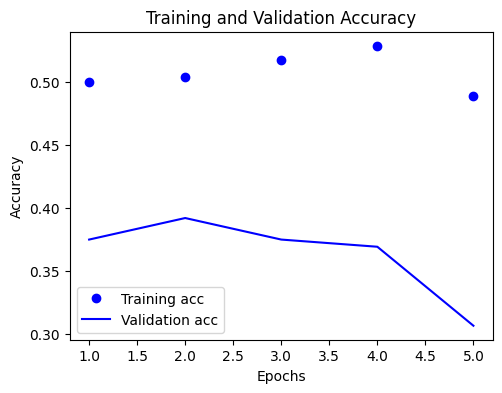

In [23]:
# Создаем график точности
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

Вывод: Training Accuracy и Validation Accuracy убывают, что означает, что модель обучается неэффективно и плохо справляется с новыми данными

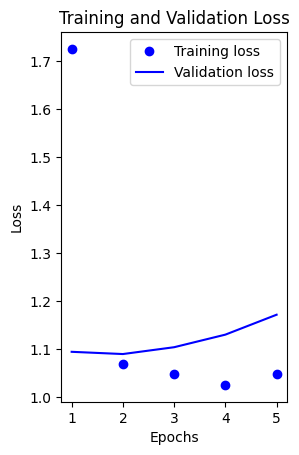

In [24]:
# Создаем график потерь
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Вывод: Training Loss и Validation Loss возрастают, что говорит, что модель недообучена и что возможно стоит провести дополнительное обучение или увеличить сложность модели. Но, повторюсь, процесс обучения прям очень долгий и мне не хватает терпения его дождаться

In [8]:
# Используем ResNet
from tensorflow.keras.applications import ResNet50
conv_base = ResNet50(weights='imagenet',
include_top=False,
input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNEL))

model = tf.keras.models.Sequential()
model.add(conv_base)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(3, activation='softmax')) # Three classes



94765736/94765736 [==============================] - 73s 1us/step


In [9]:
conv_base.trainable = False

In [10]:
# Размораживаем несколько верхних слоев
conv_base.trainable = True
fine_tune_at = 100

for layer in conv_base.layers[:fine_tune_at]:
    layer.trainable =  False

In [11]:
#Компилируем модель после любых изменений в trainable
model.compile(loss='categorical_crossentropy',
optimizer=RMSprop(lr=1e-4),
metrics=['acc'])

In [12]:
# Обучение
history = model.fit(
    train_generator,
    steps_per_epoch=TRAIN_SAMPLES // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=VAL_SAMPLES // BATCH_SIZE)

Epoch 1/5



33/33 [==============================] - 1219s 36s/step - loss: 7.7960 - acc: 0.4490 - val_loss: 90.6383 - val_acc: 0.3788
Epoch 2/5
33/33 [==============================] - 2330s 71s/step - loss: 1.0893 - acc: 0.5212 - val_loss: 26.8756 - val_acc: 0.3818
Epoch 3/5
33/33 [==============================] - 1218s 37s/step - loss: 1.0790 - acc: 0.5288 - val_loss: 10.3386 - val_acc: 0.3682
Epoch 4/5
33/33 [==============================] - 1353s 41s/step - loss: 1.0735 - acc: 0.5071 - val_loss: 3.8016 - val_acc: 0.3561
Epoch 5/5
33/33 [==============================] - 1211s 37s/step - loss: 1.0641 - acc: 0.5177 - val_loss: 1.4915 - val_acc: 0.3727


In [13]:
# Оценка модели на тестировании
score = model.evaluate(test_generator, steps=TEST_SAMPLES // BATCH_SIZE)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

11/11 [==============================] - 180s 16s/step - loss: 1.5296 - acc: 0.3652
Test loss: 1.5295593738555908
Test accuracy: 0.3651515245437622


Вывод: Test loss - это показатель ошибки на тестовом наборе данных. Большой показатель loss говорит о том, что модель делает большие ошибки при прогнозировании. Test accuracy - это показатель точности тестирования. В данном случае точность равна примерно 36.52%, что говорит о том, что модель правильно классифицировала только около 36.52% тестовых примеров.

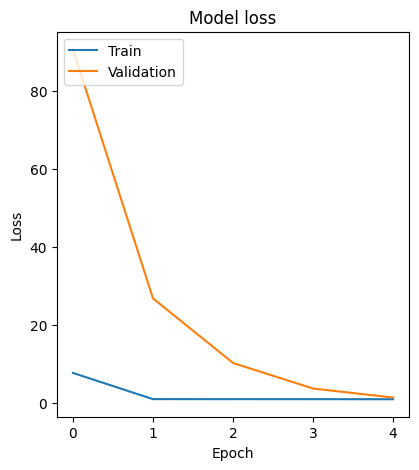

In [16]:
# Создаем график потерь
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')


Вывод: Обе линии сходятся - это хороший знак. Это означает, что модель хорошо обучается и обобщает на новых данных

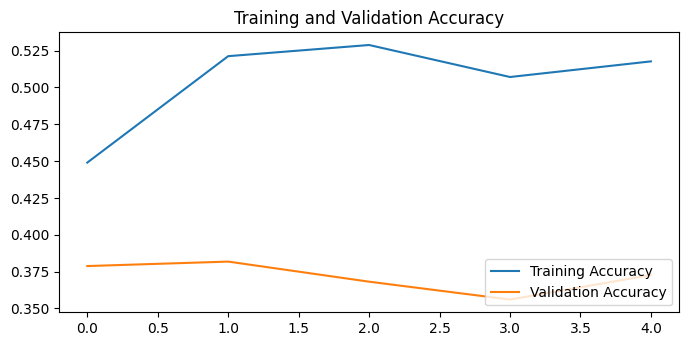

In [26]:
# Создаем график точности
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

Вывод: Training Accuracy и Validation Accuracy сначала убывают, а затем возрастают, что означает, что модель обучается эффективно и начинает справлятся с новыми данными, но лучше бы модель обучить побольше для улучшения точности, однако не хватает терпения это выжидать

In [27]:
# Сохранение модели
model.save('model.h5')

c:\users\ksenia\appdata\local\programs\python\python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Вывод
В данной работе была построена модель многоклассового классификаторас использованием сверточной основы VGG и ResNet. Результаты обучения примерно одинаковы, модели обучились не полностью (всё из-за слишком долгого обучения), однако я думаю, что втора модель вышла удачнее, поэтому было решено сохранить её